## Build anndata from `cellatac` output

In this notebook we put together the many outputs of the [cellatac pipeline](https://github.com/cellgeni/cellatac) for peak calling in scATAC-seq data into one handy anndata object, we do some important peak filtering

In [1]:
import pandas as pd 
import scanpy as sc
import numpy as np
import scipy.sparse

In [2]:
outdir = "/home/jovyan/data/lung_adult_scATAC/"
experiment_prefix = 'lungAdult_'
cellatac_outdir = '/warehouse/cellgeni/tic-619/results400k-627-13samples/'

In [3]:
input={'cnts': cellatac_outdir + 'peak_matrix/peaks_bc_matrix.mmtx.gz',
        "bcs": cellatac_outdir + 'peak_matrix/bc.txt',
      "peaks": cellatac_outdir + 'peak_matrix/peaks.txt',
      'clusters': cellatac_outdir + 'qc/seurat-clades.tsv'}

output = {
    "cnt_mmtx":outdir + experiment_prefix + '_ATAC_cisTopic.mmtx',
    "cnt_peaks":outdir + experiment_prefix + '_ATAC_cisTopic.peaks.tsv',
    "cnt_cells":outdir + experiment_prefix + '_ATAC_cisTopic.cells.tsv',
    "h5ad":outdir + experiment_prefix + '_ATAC_raw.h5ad',
}

### Make anndata object

In [38]:
adata = sc.read_mtx(input["cnts"]).T

bc = pd.read_table(input["bcs"], header=None)
feat = pd.read_table(input["peaks"], header=None)

adata.obs_names = bc[0]
adata.var_names = feat[0]

### Load peak annotations

Computed with `annotate_peaks.R`

In [41]:
peak_anno_df = pd.read_csv(outdir + "ATACpeaks_annotation.csv", index_col=0)
peak_anno_df.index = peak_anno_df["peak_id"]
peak_anno_df.drop("peak_id",1, inplace=True)
adata.var = pd.concat([adata.var, peak_anno_df], 1)

### Save binary data to layers

In [42]:
adata.layers["binary_raw"] = adata.X
adata.layers["binary_raw"][adata.layers["binary_raw"] > 1] = 1

### Peak filtering

`cellatac` calls a lot of peaks that are just noisy and downsizing the matrix a bit makes everything faster.

In [ ]:
params={'k':30, "width":210}

Preliminary filtering

In [44]:
var_qc = sc.pp.calculate_qc_metrics(adata, layer="binary_raw")
adata.var = pd.concat([adata.var, var_qc], 1)
# Accessible in at least k cells
adata = adata[:,adata.var.total_counts > params['k']] 
# Remove peaks in ENCODE blacklist
adata = adata[:, adata.var.ENCODE_blacklist==0] 
# Filter by width (remove peaks at the lowest end, closest to min peak width in MACS2)
adata = adata[:, adata.var.peak_width > params['width']] 

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [45]:
adata

View of AnnData object with n_obs × n_vars = 57992 × 372301
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

In [177]:
### Filter peaks that are not accessible in at least 10% of cells from a coarse cluster
min_frac=0.1
# Load cluster information from cellatac outputs
clusters = pd.read_table(input["clusters"], header=None, index_col=0)
clusters.columns = ["cellatac_clusters"]

In [60]:
adata.obs = clusters.loc[adata.obs_names]

In [133]:
n_clusters = len(np.unique(adata.obs[["cellatac_clusters"]]))
clus_mat = np.empty([adata.n_obs, n_clusters])
for cl in np.unique(adata.obs[["cellatac_clusters"]]):
    clus_mat[np.where(adata.obs['cellatac_clusters']==cl)[0],cl] = 1

clus_mat = scipy.sparse.csr_matrix(clus_mat)

clus_mat[clus_mat!=1] = 0

In [140]:
cl_peak_mat = np.dot(clus_mat.T, adata.layers["binary_raw"])

In [178]:
cl_peak_frac = cl_peak_mat/clus_mat.sum(0).T

In [181]:
adata = adata[:, cl_peak_frac.max(0) > min_frac]

In [6]:
adata

AnnData object with n_obs × n_vars = 57992 × 96161
    obs: 'cellatac_clusters'
    var: 'peak_width', 'exon', 'gene', 'promoter', 'annotation', 'gene_name', 'gene_id', 'tss_distance', 'ENCODE_blacklist', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'binary_raw'

### Filter cells

Often there are cells with too few counts to day anything about them and cluster together in the UMAP

In [6]:
sc.pp.calculate_qc_metrics(adata, layer="binary_raw", inplace=True)

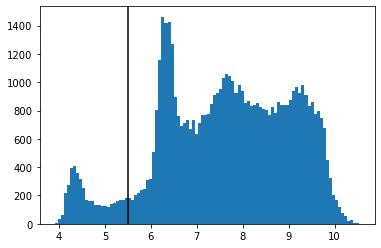

In [16]:
import matplotlib.pyplot as plt
plt.hist(adata.obs['log1p_total_counts'], bins=100);
plt.axvline(x=5.5, color="black")

In [20]:
adata = adata[adata.obs.log1p_total_counts > 5.5]

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Save

In [22]:
## Write output anndata
adata.write_h5ad(output["h5ad"])